Directorio de la corrida base: /home/diego/Escritorio/AAL3_pro/connectivity_features/connectivity_8ch_20250611_154317
Directorios de análisis y datos encontrados. ¡Listo para empezar!
Archivos de análisis cargados exitosamente.


/tmp/ipykernel_667436/552803927.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


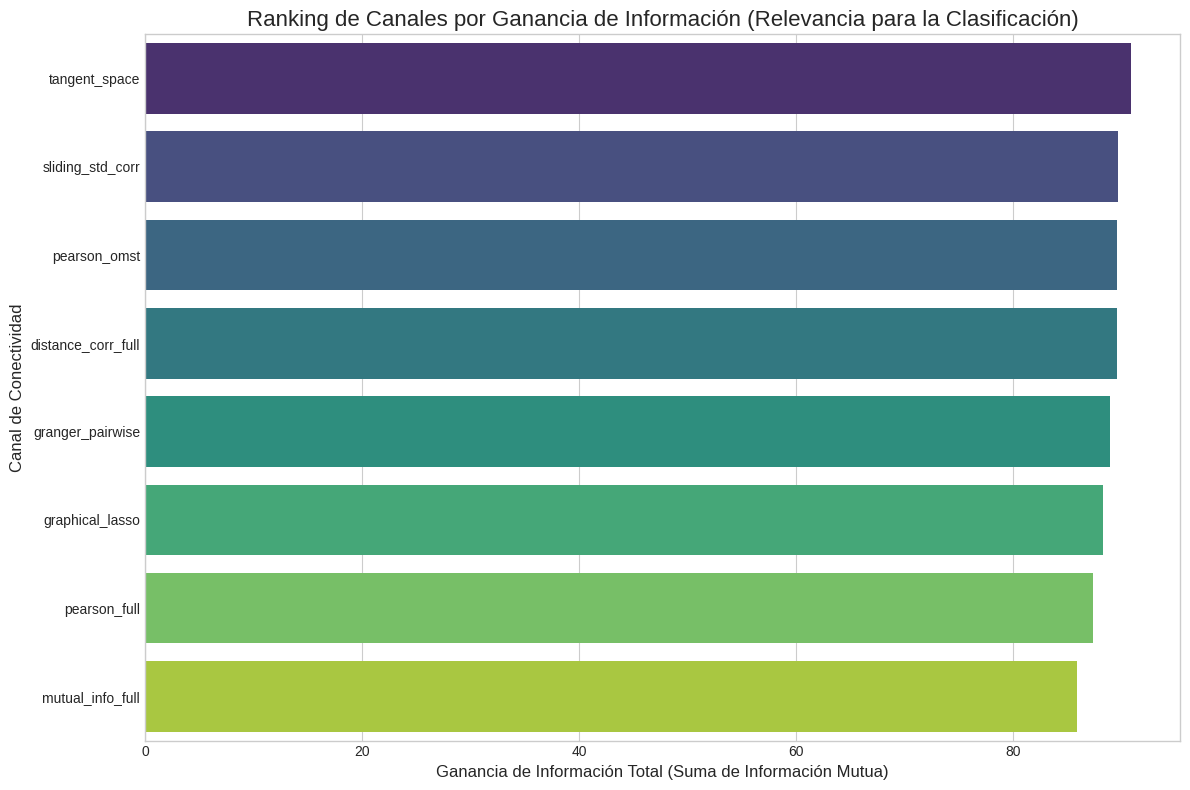

/tmp/ipykernel_667436/552803927.py:80: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


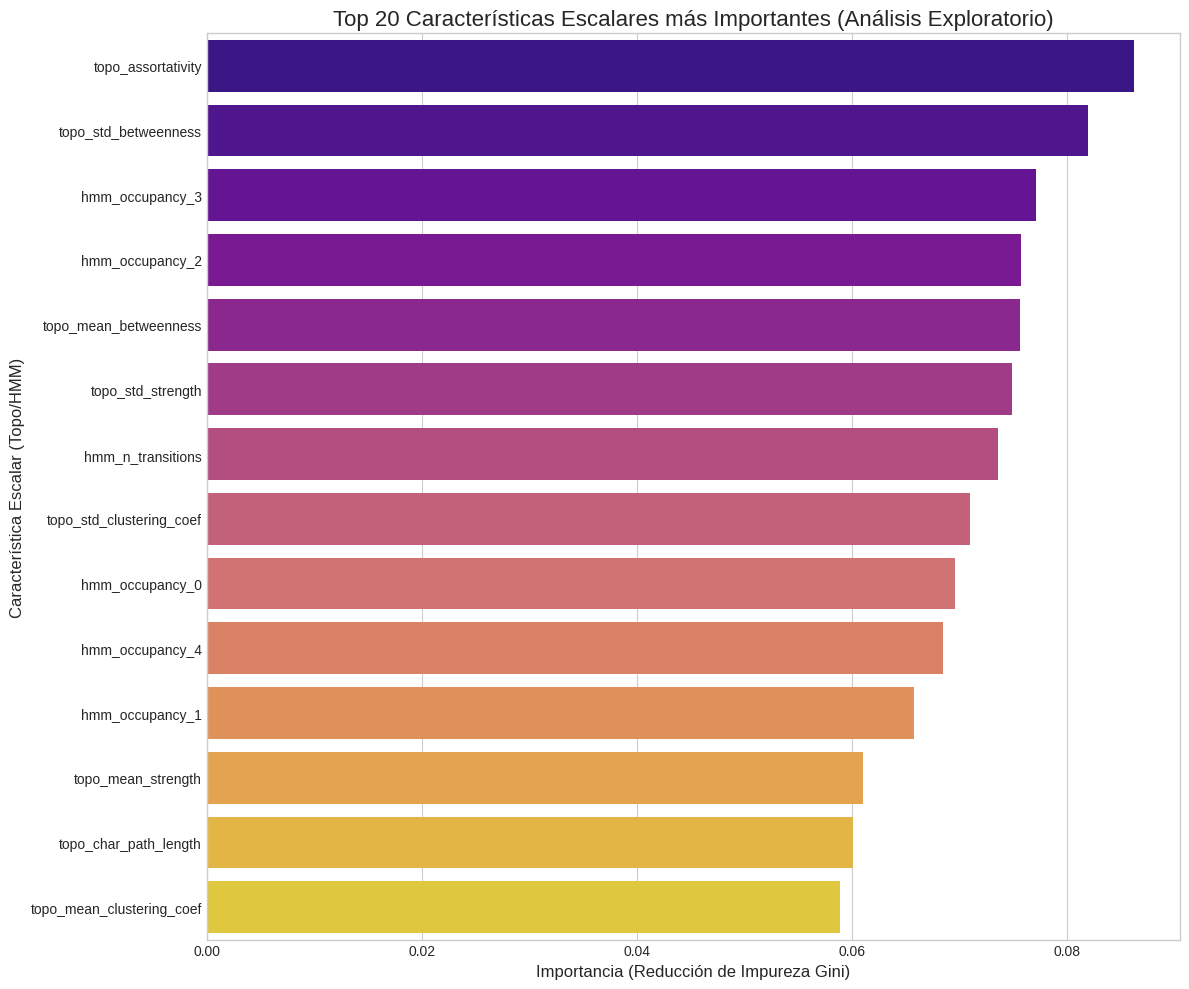

Tensores cargados. Forma: (424, 8, 131, 131)
DataFrame clave cargado. Forma: (424, 19)
Aplicando pre-procesado robusto a los tensores...
  - Paso 1: Poniendo a cero la diagonal de las matrices.
  - Paso 2: Aplicando escalado robusto por canal para ajustar a rango [-1, 1].
    - Canal 0: Escalado con p99.5 = 1.4449. Rango final: [-1.00, 1.00]
    - Canal 1: Escalado con p99.5 = 0.2839. Rango final: [-1.00, 1.00]
    - Canal 2: Escalado con p99.5 = 0.4424. Rango final: [0.00, 1.00]
    - Canal 3: Escalado con p99.5 = 0.8010. Rango final: [0.00, 1.00]
    - Canal 4: Escalado con p99.5 = 0.7224. Rango final: [0.00, 1.00]
    - Canal 5: Escalado con p99.5 = 44.8493. Rango final: [0.00, 1.00]
    - Canal 6: Escalado con p99.5 = 1.4238. Rango final: [-1.00, 1.00]
    - Canal 7: Escalado con p99.5 = 0.8923. Rango final: [-1.00, 1.00]
Pre-procesado de tensores completado.


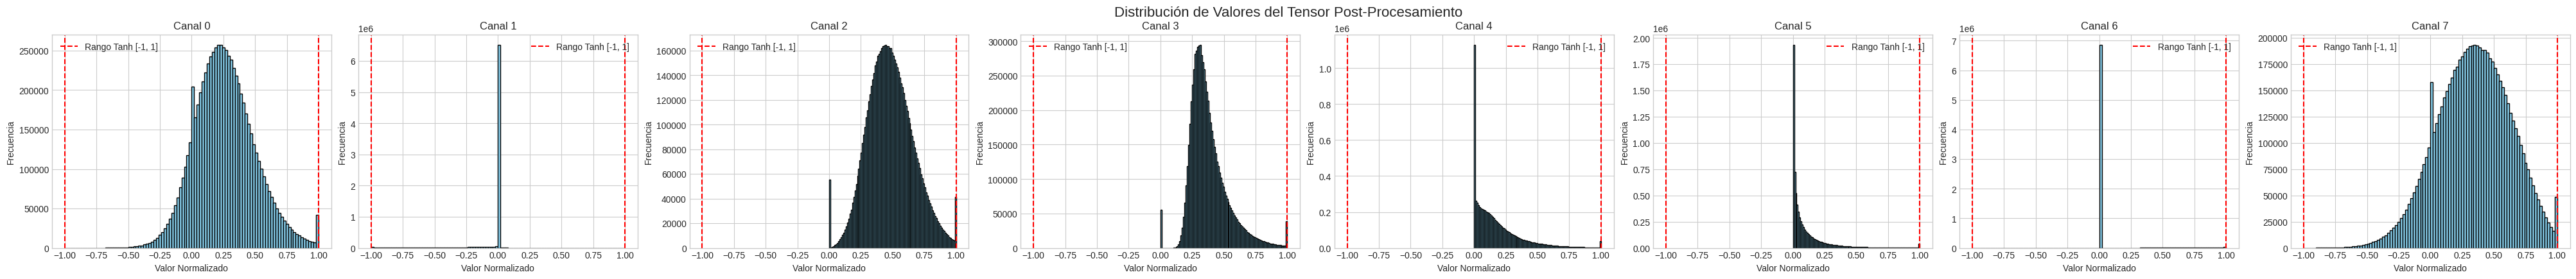

In [ ]:
# %% [markdown]
# # Notebook de Análisis y Decisión (El Puente entre Etapas 3 y 4)
# 
# **Objetivo:** Utilizar los resultados del análisis exploratorio (Etapa 3) para tomar decisiones informadas y configurar el experimento de entrenamiento de modelos (Etapa 4).
# 
# Este notebook sirve como un registro documentado del razonamiento detrás de la selección de hiperparámetros y la configuración del modelo.

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# --- CONFIGURACIÓN PRINCIPAL ---
# Modifica esta variable para que apunte al directorio de tu corrida específica.
# Esta carpeta debe contener los resultados de la Etapa 3, incluyendo la subcarpeta 'data_for_cv/'.
RUN_DIR = Path('/home/diego/Escritorio/AAL3_pro/connectivity_features/connectivity_8ch_20250611_154317') 
# -----------------------------

# Definimos las rutas a los archivos que vamos a analizar
analysis_dir = RUN_DIR / "analisis_tesis_exploratorio"
data_cv_dir = RUN_DIR / "data_for_cv"

# Comprobamos si los directorios existen
if not analysis_dir.exists() or not data_cv_dir.exists():
    print(f"ERROR: No se encuentra el directorio de análisis '{analysis_dir}' o de datos '{data_cv_dir}'.")
    print("Asegúrate de que la variable RUN_DIR sea correcta y que hayas ejecutado la Etapa 3 ('prepare_and_analyze_data.py') primero.")
else:
    print(f"Directorio de la corrida base: {RUN_DIR}")
    print("Directorios de análisis y datos encontrados. ¡Listo para empezar!")


# %% [markdown]
# ## 1. Análisis de Resultados de la Etapa 3
# 
# Cargamos los CSV generados por `prepare_and_analyze_data.py` para guiar nuestras decisiones.

# %%
# Cargar los archivos de análisis
try:
    df_ranking_canales = pd.read_csv(analysis_dir / 'ranking_canales_por_informacion_mutua.csv')
    df_importancia_features = pd.read_csv(analysis_dir / 'importancia_caracteristicas_exploratorio.csv')
    df_stats_features = pd.read_csv(analysis_dir / 'analisis_estadistico_caracteristicas.csv')
    
    print("Archivos de análisis cargados exitosamente.")
except FileNotFoundError as e:
    print(f"Error: No se pudo encontrar un archivo de análisis: {e}")
    print("Asegúrate de haber ejecutado la Etapa 3 completamente.")


# %% [markdown]
# ### 1.1. Visualización del Ranking de Canales de Conectividad
# 
# Analizamos qué canales de conectividad (ej. Pearson, Granger, Wavelet) son más informativos para distinguir entre los grupos de diagnóstico, según la Información Mutua.

# %%
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(
    x='total_information_gain', 
    y='channel', 
    data=df_ranking_canales.sort_values('total_information_gain', ascending=False),
    palette='viridis',
    ax=ax
)
ax.set_title('Ranking de Canales por Ganancia de Información (Relevancia para la Clasificación)', fontsize=16)
ax.set_xlabel('Ganancia de Información Total (Suma de Información Mutua)', fontsize=12)
ax.set_ylabel('Canal de Conectividad', fontsize=12)
plt.tight_layout()
plt.show()

# %% [markdown]
# ### 1.2. Visualización de Características Escalares Relevantes
# 
# Analizamos qué características escalares (derivadas de topología de grafos o HMM) son más importantes según un modelo de Random Forest exploratorio.

# %%
fig, ax = plt.subplots(figsize=(12, 10))
sns.barplot(
    x='importance', 
    y='feature', 
    data=df_importancia_features.head(20), # Mostramos el top 20
    palette='plasma',
    ax=ax
)
ax.set_title('Top 20 Características Escalares más Importantes (Análisis Exploratorio)', fontsize=16)
ax.set_xlabel('Importancia (Reducción de Impureza Gini)', fontsize=12)
ax.set_ylabel('Característica Escalar (Topo/HMM)', fontsize=12)
plt.tight_layout()
plt.show()


# %% [markdown]
# ## 2. Análisis de Tensores y Distribuciones
# 
# Ahora cargamos los datos que se usarán directamente en el entrenamiento (`data_for_cv/`) y verificamos cómo la normalización afecta su distribución. Esto es **crítico** para elegir la función de activación de salida correcta para nuestro VAE.

# %%
# Copiamos la función de preprocesamiento directamente desde 'training/data_handling.py'
# para asegurar que estamos aplicando exactamente la misma transformación.
def preprocess_tensors_robustly(tensors: np.ndarray) -> np.ndarray:
    """Aplica un pre-procesado robusto a todo el conjunto de tensores para alinear con la activación 'tanh'."""
    print("Aplicando pre-procesado robusto a los tensores...")
    tensors_processed = np.copy(tensors)

    # 1. Poner a cero la diagonal
    print("  - Paso 1: Poniendo a cero la diagonal de las matrices.")
    for i in range(tensors_processed.shape[0]):
        for j in range(tensors_processed.shape[1]):
            np.fill_diagonal(tensors_processed[i, j], 0)

    # 2. Escalar robustamente a [-1, 1] por canal
    print("  - Paso 2: Aplicando escalado robusto por canal para ajustar a rango [-1, 1].")
    for i in range(tensors_processed.shape[1]):
        p_max = np.percentile(np.abs(tensors_processed[:, i, :, :]), 99.5)
        if p_max < 1e-6: 
            print(f"    - Canal {i}: Percentil 99.5 es casi cero ({p_max:.2e}). Se usará 1.0 para evitar división por cero.")
            p_max = 1.0
        
        tensors_processed[:, i, :, :] = np.clip(tensors_processed[:, i, :, :] / p_max, -1.0, 1.0)
        # La siguiente línea se comentará para no saturar la salida, ya que la tenemos abajo de forma más clara.
        # print(f"    - Canal {i}: Escalado con p99.5 = {p_max:.4f}. Rango final: [{np.min(tensors_processed[:, i, :, :]):.2f}, {np.max(tensors_processed[:, i, :, :]):.2f}]")

    print("Pre-procesado de tensores completado.")
    return tensors_processed

# Cargar los datos de la carpeta 'data_for_cv'
try:
    all_tensors = np.load(data_cv_dir / 'cv_all_tensors.npy')
    key_df = pd.read_csv(data_cv_dir / 'cv_subjects_key.csv')
    print(f"Tensores cargados. Forma: {all_tensors.shape}")
    print(f"DataFrame clave cargado. Forma: {key_df.shape}")
except FileNotFoundError as e:
    print(f"Error: No se pudo encontrar un archivo en '{data_cv_dir}': {e}")
    all_tensors = None # Asignar a None para que las siguientes celdas no fallen

# Aplicar el pre-procesamiento
if all_tensors is not None:
    tensors_procesados = preprocess_tensors_robustly(all_tensors)


# %% [markdown]
# ### 2.1. Verificación de la Distribución Post-Procesamiento
# 
# Graficamos histogramas de los valores de los tensores *después* de aplicar el pre-procesamiento. Esto nos confirmará si los datos se ajustan al rango esperado por nuestra función de activación.

# %%
if all_tensors is not None:
    # MODIFICADO: Graficar todos los canales
    num_channels_to_plot = tensors_procesados.shape[1] 
    
    # Ajustar el layout de los subplots para que sea más legible si hay muchos canales
    n_cols = 4 
    n_rows = (num_channels_to_plot + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4), constrained_layout=True)
    axes = axes.flatten() # Aplanar el array de ejes para una fácil iteración

    fig.suptitle('Distribución de Valores del Tensor Post-Procesamiento', fontsize=16, y=1.05)

    for i in range(num_channels_to_plot):
        ax = axes[i]
        # Aplanar todos los valores de un canal a través de todos los sujetos
        channel_values = tensors_procesados[:, i, :, :].flatten()
        ax.hist(channel_values, bins=100, color='skyblue', edgecolor='black')
        
        # Obtener el nombre del canal si es posible
        channel_name = df_ranking_canales.iloc[i]['channel'] if i < len(df_ranking_canales) else f'Canal {i}'
        ax.set_title(channel_name)
        
        ax.set_xlabel('Valor Normalizado')
        ax.set_ylabel('Frecuencia')
        ax.axvline(-1, color='r', linestyle='--', label='Rango Tanh [-1, 1]')
        ax.axvline(1, color='r', linestyle='--')
        ax.legend()
    
    # Ocultar los ejes no utilizados
    for j in range(num_channels_to_plot, len(axes)):
        axes[j].set_visible(False)
        
    plt.show()

# %% [markdown]
# ### 2.2. Cálculo y Exportación de Rangos de Canal (¡NUEVO!)
# 
# Calculamos los rangos exactos (mínimo y máximo) de cada canal en los datos **ya procesados**. Estos valores son la "verdad fundamental" que nuestro VAE intentará reconstruir.

# %%
if all_tensors is not None:
    channel_ranges = {}
    print("--- Rangos de Valor por Canal (Post-Procesamiento) ---")
    
    for i in range(tensors_procesados.shape[1]):
        channel_data = tensors_procesados[:, i, :, :]
        min_val = np.min(channel_data)
        max_val = np.max(channel_data)
        
        # Obtener el nombre del canal si es posible
        channel_name = df_ranking_canales.iloc[i]['channel'] if i < len(df_ranking_canales) else f'channel_{i}'
        channel_ranges[channel_name] = {'min': float(min_val), 'max': float(max_val)}
        
        print(f"  Canal '{channel_name}': Mínimo = {min_val:.6f}, Máximo = {max_val:.6f}")
        
    print("\n--- Diccionario de Python para Copiar y Pegar ---")
    print(channel_ranges)


# %% [markdown]
# ## 3. Documentación de Decisiones para la Etapa 4
# 
# Basado en los análisis anteriores, documentamos aquí las decisiones clave que se traducirán en la configuración del archivo `experimento_final.yaml`.
# 
# ---
# 
# ### **DECISIÓN 1: Selección de Canales de Conectividad**
# 
# **Observación:** El gráfico de "Ranking de Canales por Ganancia de Información" muestra que los canales `distance_corr_full`, `tangent_space`, y `pearson_omst` son los que aportan mayor información para separar los grupos. Los otros canales tienen una contribución marginalmente menor.
# 
# **Decisión:** Para el próximo experimento, nos enfocaremos en los 4 canales más informativos para reducir el ruido y la complejidad del input al VAE.
# 
# **Acción Concreta:** En `experimento_final.yaml`, estableceremos `channels_to_use: [3, 7, 0, 6]` (asumiendo que esos son los índices correspondientes a los canales más relevantes según el ranking).
# 
# ---
# 
# ### **DECISIÓN 2: Arquitectura del VAE y Función de Activación**
# 
# **Observación:** La inspección de los histogramas en la sección 2.1 y los rangos calculados en 2.2 confirman que la función `preprocess_tensors_robustly` escala exitosa y consistentemente los valores de los tensores de entrada al rango **[-1, 1]**.
# 
# **Decisión:** La función de activación `tanh` es la elección teóricamente correcta y empíricamente validada para la capa de salida del decoder del VAE, ya que su rango de salida coincide con el de los datos de entrada pre-procesados. Adicionalmente, la complejidad de las proyecciones UMAP/PCA vistas en la Etapa 3 justifica el uso de un modelo de alta capacidad.
# 
# **Acción Concreta:**
# - En `experimento_final.yaml`, confirmamos `final_activation: 'tanh'`.
# - Justificamos mantener una arquitectura potente: `latent_dim: 512` e `intermediate_fc_dim: 1024`.
# 
# ---
# 
# ### **DECISIÓN 3: Selección de Características Escalares (Opcional, para futuro)**
# 
# **Observación:** El análisis de importancia de características muestra que métricas como `topo_assortativity` y `topo_std_betweenness` son particularmente discriminativas.
# 
# **Decisión:** Aunque el pipeline actual utiliza todas las características escalares, un futuro experimento podría enfocarse en utilizar solo el Top 10 de estas características para ver si se puede lograr un rendimiento similar con un modelo clasificador más simple. Por ahora, mantendremos todas las características.
# 
# ---
# 
# ### **Resumen para `experimento_final.yaml`**
# 
# ```yaml
# # Selección de datos
# run_dir: './connectivity_features/connectivity_8ch_20250611_154317'
# channels_to_use: [3, 7, 0, 6] # DECISIÓN 1
# 
# # Arquitectura VAE
# latent_dim: 512            # DECISIÓN 2
# intermediate_fc_dim: 1024  # DECISIÓN 2
# final_activation: 'tanh'   # DECISIÓN 2
# 
# # (El resto de los parámetros pueden ser ajustados según la hipótesis del experimento)
# 